The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.17.1


# Cálculo de Variável Única
:label:`sec_single_variable_calculus`

Em :numref:`sec_calculus`, vimos os elementos básicos do cálculo diferencial. Esta seção dá um mergulho mais profundo nos fundamentos do cálculo e como podemos entendê-lo e aplicá-lo no contexto do aprendizado de máquina.

## Cálculo diferencial

O cálculo diferencial é fundamentalmente o estudo de como as funções se comportam sob pequenas mudanças. Para ver por que isso é tão importante para o*deep learning*, vamos considerar um exemplo.

Suponha que temos uma rede neural profunda onde os pesos são, por conveniência, concatenados em um único vetor $\mathbf{w} = (w_1, \ldots, w_n)$. Dado um conjunto de dados de treinamento, consideramos a perda de nossa rede neural neste conjunto de dados, que escreveremos como $\mathcal{L}(\mathbf{w})$.  

Esta função é extraordinariamente complexa, codificando o desempenho de todos os modelos possíveis da arquitetura dada neste conjunto de dados, então é quase impossível dizer qual conjunto de pesos $\mathbf{w}$ irá minimizar a perda. Assim, na prática, geralmente começamos inicializando nossos pesos *aleatoriamente* e, em seguida, damos passos pequenos iterativamente na direção que faz com que a perda diminua o mais rápido possível.


A questão então se torna algo que superficialmente não é mais fácil: como encontramos a direção que faz com que os pesos diminuam o mais rápido possível? Para nos aprofundarmos nisso, vamos primeiro examinar o caso com apenas um único peso: $L(\mathbf{w}) = L(x)$ para um único valor real $x$.

Vamos pegar $x$ e tentar entender o que acontece quando o alteramos por uma pequena quantia para $x + \epsilon$. Se você deseja ser concreto, pense em um número como $\epsilon = 0.0000001$. Para nos ajudar a visualizar o que acontece, vamos representar graficamente uma função de exemplo, $f(x) = \sin(x^x)$, sobre $[0, 3]$.


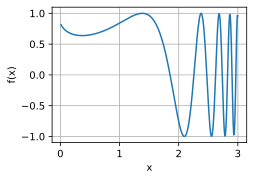

In [1]:
%matplotlib inline
import torch
from IPython import display
from d2l import torch as d2l

torch.pi = torch.acos(torch.zeros(1)).item() * 2  # Define pi in torch

# Plot a function in a normal range
x_big = torch.arange(0.01, 3.01, 0.01)
ys = torch.sin(x_big**x_big)
d2l.plot(x_big, ys, 'x', 'f(x)')

Em grande escala, o comportamento da função não é simples. No entanto, se reduzirmos nosso intervalo para algo menor como $[1.75,2.25]$, vemos que o gráfico se torna muito mais simples.


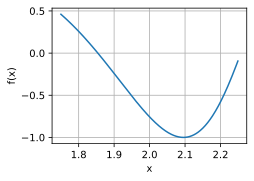

In [2]:
# Plot a the same function in a tiny range
x_med = torch.arange(1.75, 2.25, 0.001)
ys = torch.sin(x_med**x_med)
d2l.plot(x_med, ys, 'x', 'f(x)')

Levando isso ao extremo, se ampliarmos em um segmento minúsculo, o comportamento se torna muito mais simples: é apenas uma linha reta.


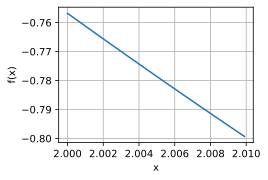

In [3]:
# Plot a the same function in a tiny range
x_small = torch.arange(2.0, 2.01, 0.0001)
ys = torch.sin(x_small**x_small)
d2l.plot(x_small, ys, 'x', 'f(x)')

Esta é a observação chave do cálculo de variável única: o comportamento de funções familiares pode ser modelado por uma linha em um intervalo pequeno o suficiente. Isso significa que, para a maioria das funções, é razoável esperar que, à medida que deslocamos um pouco o valor $x$ da função, a saída $f(x)$ também seja deslocada um pouco. A única pergunta que precisamos responder é: "Qual é o tamanho da mudança na produção em comparação com a mudança na entrada? É a metade? Duas vezes maior?"

Assim, podemos considerar a razão da mudança na saída de uma função para uma pequena mudança na entrada da função. Podemos escrever isso formalmente como

$$
\frac{L(x+\epsilon) - L(x)}{(x+\epsilon) - x} = \frac{L(x+\epsilon) - L(x)}{\epsilon}.
$$

Isso já é o suficiente para começar a brincar com o código. Por exemplo, suponha que saibamos que $L(x) = x^{2} + 1701(x-4)^3$, então podemos ver o quão grande é esse valor no ponto $x = 4$ como segue.


In [4]:
# Define our function
def L(x):
    return x**2 + 1701*(x-4)**3

# Print the difference divided by epsilon for several epsilon
for epsilon in [0.1, 0.001, 0.0001, 0.00001]:
    print(f'epsilon = {epsilon:.5f} -> {(L(4+epsilon) - L(4)) / epsilon:.5f}')

epsilon = 0.10000 -> 25.11000
epsilon = 0.00100 -> 8.00270
epsilon = 0.00010 -> 8.00012
epsilon = 0.00001 -> 8.00001


Agora, se formos observadores, notaremos que a saída desse número é suspeitamente próxima de $8$. De fato, se diminuirmos $\epsilon$, veremos que o valor se torna progressivamente mais próximo de $8$. Assim, podemos concluir, corretamente, que o valor que buscamos (o grau em que uma mudança na entrada muda a saída) deve ser $8$ no ponto $x=4$. A forma como um matemático codifica este fato é

$$
\lim_{\epsilon \rightarrow 0}\frac{L(4+\epsilon) - L(4)}{\epsilon} = 8.
$$


Como uma pequena digressão histórica: nas primeiras décadas de pesquisa de redes neurais, os cientistas usaram este algoritmo (o *método das diferenças finitas*) para avaliar como uma função de perda mudou sob pequenas perturbações: basta alterar os pesos e ver como o perda mudou. Isso é computacionalmente ineficiente, exigindo duas avaliações da função de perda para ver como uma única mudança de uma variável influenciou a perda. Se tentássemos fazer isso mesmo com alguns poucos milhares de parâmetros, seriam necessários vários milhares de avaliações da rede em todo o conjunto de dados! Não foi resolvido até 1986 que o *algoritmo de retropropagação* introduzido em :cite:`Rumelhart.Hinton.Williams.ea.1988` forneceu uma maneira de calcular como *qualquer* alteração dos pesos juntos mudaria a perda no mesmo cálculo tempo como uma única previsão da rede no conjunto de dados.

De volta ao nosso exemplo, este valor $8$ é diferente para diferentes valores de $x$, então faz sentido defini-lo como uma função de $x$. Mais formalmente, esta taxa de variação dependente do valor é referida como a *derivada* que é escrita como

$$\frac{df}{dx}(x) = \lim_{\epsilon \rightarrow 0}\frac{f(x+\epsilon) - f(x)}{\epsilon}.$$
:eqlabel:`eq_der_def`

Textos diferentes usarão notações diferentes para a derivada. Por exemplo, todas as notações abaixo indicam a mesma coisa:
$$
\frac{df}{dx} = \frac{d}{dx}f = f' = \nabla_xf = D_xf = f_x.
$$

A maioria dos autores escolherá uma única notação e a manterá, porém nem isso é garantido. É melhor estar familiarizado com tudo isso. Usaremos a notação $\frac{df}{dx}$ ao longo deste texto, a menos que queiramos tirar a derivada de uma expressão complexa, caso em que usaremos $\frac{d}{dx}f$ para escrever expressões como
$$
\frac{d}{dx}\left[x^4+\cos\left(\frac{x^2+1}{2x-1}\right)\right].
$$

Muitas vezes, é intuitivamente útil desvendar a definição de derivada :eqref:`eq_der_def` novamente para ver como uma função muda quando fazemos uma pequena mudança de $x$:

$$\begin{aligned} \frac{df}{dx}(x) = \lim_{\epsilon \rightarrow 0}\frac{f(x+\epsilon) - f(x)}{\epsilon} & \implies \frac{df}{dx}(x) \approx \frac{f(x+\epsilon) - f(x)}{\epsilon} \\ & \implies \epsilon \frac{df}{dx}(x) \approx f(x+\epsilon) - f(x) \\ & \implies f(x+\epsilon) \approx f(x) + \epsilon \frac{df}{dx}(x). \end{aligned}$$
:eqlabel:`eq_small_change`


Vale a pena mencionar explicitamente a última equação. Isso nos diz que se você pegar qualquer função e alterar a entrada em um pequeno valor, a saída mudará nesse pequeno valor escalonado pela derivada.

Desta forma, podemos entender a derivada como o fator de escala que nos diz quão grande é a mudança que obtemos na saída de uma mudança na entrada.

## Regras de Cálculo
:label:`sec_derivative_table`

Agora nos voltamos para a tarefa de entender como calcular a derivada de uma função explícita. Um tratamento formal completo do cálculo derivaria tudo dos primeiros princípios. Não vamos ceder a esta tentação aqui, mas sim fornecer uma compreensão das regras comuns encontradas.

### Derivadas Comuns
Como foi visto em :numref:`sec_calculus`, ao calcular derivadas, muitas vezes pode-se usar uma série de regras para reduzir o cálculo a algumas funções básicas. Nós os repetimos aqui para facilitar a referência.

* **Derivada de constantes.** $\frac{d}{dx}c = 0$.
* **Derivada de funções lineares.** $\frac{d}{dx}(ax) = a$.
* **Regra de potência.** $\frac{d}{dx}x^n = nx^{n-1}$.
* **Derivada de exponenciais.** $\frac{d}{dx}e^x = e^x$.
* **Derivada do logaritmo.** $\frac{d}{dx}\log(x) = \frac{1}{x}$.

### Regras de Derivadas
Se cada derivada precisasse ser calculada separadamente e armazenada em uma tabela, o cálculo diferencial seria quase impossível. É um presente da matemática que podemos generalizar as derivadas acima e calcular derivadas mais complexas, como encontrar a derivada de $f(x) = \log\left(1+(x-1)^{10}\right)$. Como foi mencionado em :numref:`sec_calculus`, a chave para fazer isso é codificar o que acontece quando pegamos funções e as combinamos de várias maneiras, o mais importante: somas, produtos e composições.

* **Regra da soma.** $\frac{d}{dx}\left(g(x) + h(x)\right) = \frac{dg}{dx}(x) + \frac{dh}{dx}(x)$.
* **Regra do produto.** $\frac{d}{dx}\left(g(x)\cdot h(x)\right) = g(x)\frac{dh}{dx}(x) + \frac{dg}{dx}(x)h(x)$.
* **Regra da cadeia.** $\frac{d}{dx}g(h(x)) = \frac{dg}{dh}(h(x))\cdot \frac{dh}{dx}(x)$.

Vamos ver como podemos usar :eqref:`eq_small_change` para entender essas regras. Para a regra da soma, considere a seguinte cadeia de raciocínio:

$$
\begin{aligned}
f(x+\epsilon) & = g(x+\epsilon) + h(x+\epsilon) \\
& \approx g(x) + \epsilon \frac{dg}{dx}(x) + h(x) + \epsilon \frac{dh}{dx}(x) \\
& = g(x) + h(x) + \epsilon\left(\frac{dg}{dx}(x) + \frac{dh}{dx}(x)\right) \\
& = f(x) + \epsilon\left(\frac{dg}{dx}(x) + \frac{dh}{dx}(x)\right).
\end{aligned}
$$


Comparando este resultado com o fato de que  $f(x+\epsilon) \approx f(x) + \epsilon \frac{df}{dx}(x)$ vemos que $\frac{df}{dx}(x) = \frac{dg}{dx}(x) + \frac{dh}{dx}(x)$ conforme desejado. A intuição aqui é: quando mudamos a entrada $x$, $g$ e $h$ contribuem conjuntamente para a mudança da saída $\frac{dg}{dx}(x)$ e $\frac{dh}{dx}(x)$.


O produto é mais sutil e exigirá uma nova observação sobre como trabalhar com essas expressões. Começaremos como antes usando :eqref:`eq_small_change`:

$$
\begin{aligned}
f(x+\epsilon) & = g(x+\epsilon)\cdot h(x+\epsilon) \\
& \approx \left(g(x) + \epsilon \frac{dg}{dx}(x)\right)\cdot\left(h(x) + \epsilon \frac{dh}{dx}(x)\right) \\
& = g(x)\cdot h(x) + \epsilon\left(g(x)\frac{dh}{dx}(x) + \frac{dg}{dx}(x)h(x)\right) + \epsilon^2\frac{dg}{dx}(x)\frac{dh}{dx}(x) \\
& = f(x) + \epsilon\left(g(x)\frac{dh}{dx}(x) + \frac{dg}{dx}(x)h(x)\right) + \epsilon^2\frac{dg}{dx}(x)\frac{dh}{dx}(x). \\
\end{aligned}
$$


Isso se assemelha ao cálculo feito acima, e de fato vemos nossa resposta ($\frac{df}{dx}(x) = g(x)\frac{dh}{dx}(x) + \frac{dg}{dx}(x)h(x)$) sentado ao lado de $\epsilon$, mas há a questão desse termo de tamanho $\epsilon^{2}$. Iremos nos referir a isso como um *termo de ordem superior*, uma vez que a potência de $\epsilon^2$ é maior do que a potência de $\epsilon^1$. Veremos em uma seção posterior que às vezes desejaremos mantê-los sob controle; no entanto, por enquanto, observe que se $\epsilon = 0.0000001$, então $\epsilon^{2}= 0.0000000000001$, que é muito menor. Conforme enviamos $\epsilon \rightarrow 0$, podemos ignorar com segurança os termos de pedido superior. Como uma convenção geral neste apêndice, usaremos "$\approx$" para denotar que os dois termos são iguais até os termos de ordem superior. No entanto, se quisermos ser mais formais, podemos examinar o quociente de diferença
$$
\frac{f(x+\epsilon) - f(x)}{\epsilon} = g(x)\frac{dh}{dx}(x) + \frac{dg}{dx}(x)h(x) + \epsilon \frac{dg}{dx}(x)\frac{dh}{dx}(x),
$$


e veja que conforme enviamos $\epsilon \rightarrow 0$, o termo do lado direito vai para zero também.

Finalmente, com a regra da cadeia, podemos novamente progredir como antes usando :eqref:`eq_small_change` e ver que

$$
\begin{aligned}
f(x+\epsilon) & = g(h(x+\epsilon)) \\
& \approx g\left(h(x) + \epsilon \frac{dh}{dx}(x)\right) \\
& \approx g(h(x)) + \epsilon \frac{dh}{dx}(x) \frac{dg}{dh}(h(x))\\
& = f(x) + \epsilon \frac{dg}{dh}(h(x))\frac{dh}{dx}(x),
\end{aligned}
$$


onde na segunda linha vemos a função $g$ como tendo sua entrada ($h(x)$) deslocada pela pequena quantidade $\epsilon \frac{dh}{dx}(x)$.

Essa regra nos fornece um conjunto flexível de ferramentas para calcular essencialmente qualquer expressão desejada. Por exemplo,

$$
\begin{aligned}
\frac{d}{dx}\left[\log\left(1+(x-1)^{10}\right)\right] & = \left(1+(x-1)^{10}\right)^{-1}\frac{d}{dx}\left[1+(x-1)^{10}\right]\\
& = \left(1+(x-1)^{10}\right)^{-1}\left(\frac{d}{dx}[1] + \frac{d}{dx}[(x-1)^{10}]\right) \\
& = \left(1+(x-1)^{10}\right)^{-1}\left(0 + 10(x-1)^9\frac{d}{dx}[x-1]\right) \\
& = 10\left(1+(x-1)^{10}\right)^{-1}(x-1)^9 \\
& = \frac{10(x-1)^9}{1+(x-1)^{10}}.
\end{aligned}
$$


Onde cada linha usou as seguintes regras:

1. A regra da cadeia e derivada do logaritmo.
2. A regra da soma.
3. A derivada de constantes, regra da cadeia e regra de potência.
4. A regra da soma, derivada de funções lineares, derivada de constantes.

Duas coisas devem ficar claras depois de fazer este exemplo:


1. Qualquer função que possamos escrever usando somas, produtos, constantes, potências, exponenciais e logaritmos pode ter sua derivada calculada mecanicamente seguindo essas regras.
2. Fazer com que um humano siga essas regras pode ser entediante e sujeito a erros!

Felizmente, esses dois fatos juntos apontam para um caminho a seguir: este é um candidato perfeito para a mecanização! Na verdade, a retropropagação, que revisitaremos mais tarde nesta seção, é exatamente isso.

### Aproximação Linear
Ao trabalhar com derivadas, geralmente é útil interpretar geometricamente a aproximação usada acima. Em particular, observe que a equação
$$
f(x+\epsilon) \approx f(x) + \epsilon \frac{df}{dx}(x),
$$

aproxima o valor de $f$ por uma linha que passa pelo ponto $(x, f(x))$ e tem inclinação $\frac{df}{dx}(x)$. Desta forma, dizemos que a derivada dá uma aproximação linear para a função $f$, conforme ilustrado abaixo:


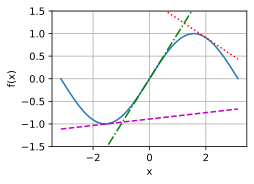

In [5]:
# Compute sin
xs = torch.arange(-torch.pi, torch.pi, 0.01)
plots = [torch.sin(xs)]

# Compute some linear approximations. Use d(sin(x))/dx = cos(x)
for x0 in [-1.5, 0.0, 2.0]:
    plots.append(torch.sin(torch.tensor(x0)) + (xs - x0) *
                 torch.cos(torch.tensor(x0)))

d2l.plot(xs, plots, 'x', 'f(x)', ylim=[-1.5, 1.5])

### Derivadas de Ordem Superior


Vamos agora fazer algo que pode parecer estranho superficialmente. Pegue uma função $f$ e calcule a derivada $\frac{df}{dx}$. Isso nos dá a taxa de variação de $f$ em qualquer ponto.

No entanto, a derivada, $\frac{df}{dx}$, pode ser vista como uma função em si, então nada nos impede de calcular a derivada de $\frac{df}{dx}$ para obter $\frac{d^2f}{dx^2} = \frac{df}{dx}\left(\frac{df}{dx}\right)$.. Chamaremos isso de segunda derivada de $f$. Esta função é a taxa de variação da taxa de variação de $f$, ou em outras palavras, como a taxa de variação está mudando. Podemos aplicar a derivada qualquer número de vezes para obter o que é chamado de $n$-ésima derivada. Para manter a notação limpa, denotaremos a derivada $n$-ésima

$$
f^{(n)}(x) = \frac{d^{n}f}{dx^{n}} = \left(\frac{d}{dx}\right)^{n} f.
$$

Vamos tentar entender *por que* essa noção é útil. Abaixo, visualizamos $f^{(2)}(x)$, $f^{(1)}(x)$, and $f(x)$.  

Primeiro, considere o caso em que a segunda derivada $f^{(2)}(x)$ é uma constante positiva. Isso significa que a inclinação da primeira derivada é positiva. Como resultado, a primeira derivada $f^{(1)}(x)$  pode começar negativa, tornar-se zero em um ponto e então se tornar positiva no final. Isso nos diz a inclinação de nossa função original $f$ e, portanto, a própria função $f$ diminui, nivela e, em seguida, aumenta. Em outras palavras, a função $f$ se curva para cima e tem um único mínimo como é mostrado em :numref:`fig_positive-second`.

![Se assumirmos que a segunda derivada é uma constante positiva, então a primeira derivada está aumentando, o que implica que a própria função tem um mínimo.](http://d2l.ai/_images/posSecDer.svg)
:label:`fig_positive-second`


Em segundo lugar, se a segunda derivada é uma constante negativa, isso significa que a primeira derivada está diminuindo. Isso implica que a primeira derivada pode começar positiva, tornar-se zero em um ponto e, em seguida, tornar-se negativa. Conseqüentemente, a própria função $f$ aumenta, nivela e depois diminui. Em outras palavras, a função $f$ se curva para baixo e tem um único máximo, conforme mostrado em :numref:`fig_negative-second`.

![Se assumirmos que a segunda derivada é uma constante negativa, então a primeira derivada decrescente, o que implica que a própria função tem um máximo.](http://d2l.ai/_images/negSecDer.svg)
:label:`fig_negative-second`


Terceiro, se a segunda derivada é sempre zero, então a primeira derivada nunca mudará - ela é constante! Isso significa que $f$ aumenta (ou diminui) a uma taxa fixa, e $f$ é em si uma linha reta como mostrado em :numref:`fig_zero-second`.

![Se assumirmos que a segunda derivada é zero, a primeira derivada é constante, o que implica que a própria função é uma linha reta.](http://d2l.ai/_images/zeroSecDer.svg)
:label:`fig_zero-second`


Para resumir, a segunda derivada pode ser interpretada como descrevendo a forma como a função $f$ curva. Uma segunda derivada positiva leva a uma curva para cima, enquanto uma segunda derivada negativa significa que $f$ se curva para baixo, e uma segunda derivada zero significa que $f$ não faz nenhuma curva.

Vamos dar um passo adiante. Considere a função $g(x) = ax^{2}+ bx + c$. Podemos então calcular que

$$
\begin{aligned}
\frac{dg}{dx}(x) & = 2ax + b \\
\frac{d^2g}{dx^2}(x) & = 2a.
\end{aligned}
$$

Se tivermos alguma função original $f(x)$ em mente, podemos calcular as duas primeiras derivadas e encontrar os valores para $a, b$, e $c$ que os fazem corresponder a este cálculo. Similarmente à seção anterior, onde vimos que a primeira derivada deu a melhor aproximação com uma linha reta, esta construção fornece a melhor aproximação por uma quadrática. Vamos visualizar isso para $f(x) = \sin(x)$.


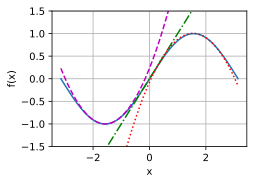

In [6]:
# Compute sin
xs = torch.arange(-torch.pi, torch.pi, 0.01)
plots = [torch.sin(xs)]

# Compute some quadratic approximations. Use d(sin(x)) / dx = cos(x)
for x0 in [-1.5, 0.0, 2.0]:
    plots.append(torch.sin(torch.tensor(x0)) + (xs - x0) *
                 torch.cos(torch.tensor(x0)) - (xs - x0)**2 *
                 torch.sin(torch.tensor(x0)) / 2)

d2l.plot(xs, plots, 'x', 'f(x)', ylim=[-1.5, 1.5])

Vamos estender essa ideia para a ideia de uma *série de Taylor* na próxima seção.

### Séries de Taylor



A *série de Taylor* fornece um método para aproximar a função $f(x)$ se recebermos valores para as primeiros $n$ derivadas em um ponto $x_0$, i.e., $\left\{ f(x_0), f^{(1)}(x_0), f^{(2)}(x_0), \ldots, f^{(n)}(x_0) \right\}$. A ideia será encontrar um polinômio de grau $n$ que corresponda a todas as derivadas fornecidas em $x_0$.

Vimos o caso de $n=2$ na seção anterior e um pouco de álgebra mostra que isso é

$$
f(x) \approx \frac{1}{2}\frac{d^2f}{dx^2}(x_0)(x-x_0)^{2}+ \frac{df}{dx}(x_0)(x-x_0) + f(x_0).
$$


Como podemos ver acima, o denominador de $2$ está aí para cancelar os $2$ que obtemos quando tomamos duas derivadas de $x^2$, enquanto os outros termos são todos zero. A mesma lógica se aplica à primeira derivada e ao próprio valor.

Se empurrarmos a lógica ainda mais para $n=3$, concluiremos que

$$
f(x) \approx \frac{\frac{d^3f}{dx^3}(x_0)}{6}(x-x_0)^3 + \frac{\frac{d^2f}{dx^2}(x_0)}{2}(x-x_0)^{2}+ \frac{df}{dx}(x_0)(x-x_0) + f(x_0).
$$


onde $6 = 3 \times 2 = 3!$ vem da constante que obtemos na frente se tomarmos três derivadas de $x^3$.


Além disso, podemos obter um polinômio de grau $n$ por

$$
P_n(x) = \sum_{i = 0}^{n} \frac{f^{(i)}(x_0)}{i!}(x-x_0)^{i}.
$$

onde a notação

$$
f^{(n)}(x) = \frac{d^{n}f}{dx^{n}} = \left(\frac{d}{dx}\right)^{n} f.
$$



De fato, $P_n(x)$ pode ser visto como a melhor aproximação polinomial de $n$-ésimo grau para nossa função $f(x)$.

Embora não vamos mergulhar totalmente no erro das aproximações acima, vale a pena mencionar o limite infinito. Neste caso, para funções bem comportadas (conhecidas como funções analíticas reais) como $\cos(x)$ or $e^{x}$, podemos escrever o número infinito de termos e aproximar exatamente a mesma função

$$
f(x) = \sum_{n = 0}^\infty \frac{f^{(n)}(x_0)}{n!}(x-x_0)^{n}.
$$

Tome $f(x) = e^{x}$ como um exemplo. Como $e^{x}$ é sua própria derivada, sabemos que $f^{(n)}(x) = e^{x}$. Portanto, $e^{x}$ pode ser reconstruído tomando a série de Taylor em $x_0 = 0$, ou seja,

$$
e^{x} = \sum_{n = 0}^\infty \frac{x^{n}}{n!} = 1 + x + \frac{x^2}{2} + \frac{x^3}{6} + \cdots.
$$

Vamos ver como isso funciona no código e observar como o aumento do grau da aproximação de Taylor nos aproxima da função desejada $e^x$.


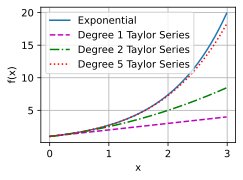

In [7]:
# Compute the exponential function
xs = torch.arange(0, 3, 0.01)
ys = torch.exp(xs)

# Compute a few Taylor series approximations
P1 = 1 + xs
P2 = 1 + xs + xs**2 / 2
P5 = 1 + xs + xs**2 / 2 + xs**3 / 6 + xs**4 / 24 + xs**5 / 120

d2l.plot(xs, [ys, P1, P2, P5], 'x', 'f(x)', legend=[
    "Exponential", "Degree 1 Taylor Series", "Degree 2 Taylor Series",
    "Degree 5 Taylor Series"])

A série Taylor tem duas aplicações principais:

1. *Aplicações teóricas*: Freqüentemente, quando tentamos entender uma função muito complexa, usar a série de Taylor nos permite transformá-la em um polinômio com o qual podemos trabalhar diretamente.

2. *Aplicações numéricas*: Algumas funções como $e^{x}$ ou $\cos(x)$ são difíceis de serem computadas pelas máquinas. Eles podem armazenar tabelas de valores com uma precisão fixa (e isso geralmente é feito), mas ainda deixa questões em aberto como "Qual é o milésimo dígito de $\cos(1)$?" As séries de Taylor costumam ser úteis para responder a essas perguntas.


## Resumo

* As derivadas podem ser usadas para expressar como as funções mudam quando alteramos a entrada em um pequeno valor.
* Derivadas elementares podem ser combinadas usando regras de derivadas para criar derivadas arbitrariamente complexas.
* As derivadas podem ser iteradas para obter derivadas de segunda ordem ou de ordem superior. Cada aumento na ordem fornece informações mais refinadas sobre o comportamento da função.
* Usando informações nas derivadas de um único exemplo de dados, podemos aproximar funções bem comportadas por polinômios obtidos da série de Taylor.


## Exercícios

1. Qual é a derivada de $x^3-4x+1$?
2. Qual é a derivada de $\log(\frac{1}{x})$?
3. Verdadeiro ou falso: Se $f'(x) = 0$ então $f$ tem um máximo ou mínimo de $x$?
4. Onde está o mínimo de $f(x) = x\log(x)$ para $x\ge0$ (onde assumimos que $f$ assume o valor limite de $0$ em $f(0)$)?


[Discussões](https://discuss.d2l.ai/t/1088)


<!--stackedit_data:
eyJoaXN0b3J5IjpbLTgzMjAwOTY2MCwxMDU3MzU4NzgsLTQ5Mz
kxOTgwNiwtNTI2MTQzNjYzLDIxMTY1NjIyNTIsLTEwMjkyNTE2
NDYsLTEyOTA2MjI5NzIsLTExMzM5Mjg4MzJdfQ==
-->
